In [3]:
%matplotlib inline
import os
import time
import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
import scipy.io
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import scipy.misc

from darknet import Darknet
import dataset
from utils import *
from MeshPly import MeshPly

# Create new directory
def makedirs(path):
    if not os.path.exists( path ):
        os.makedirs( path )

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 max          2 x 2 / 2   416 x 416 x  32   ->   208 x 208 x  32
    2 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    3 max          2 x 2 / 2   208 x 208 x  64   ->   104 x 104 x  64
    4 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    5 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    6 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    7 max          2 x 2 / 2   104 x 104 x 128   ->    52 x  52 x 128
    8 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
    9 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   10 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   11 max          2 x 2 / 2    52 x  52 x 256   ->    26 x  26 x 256
   12 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512
   13 conv    256  1 x 

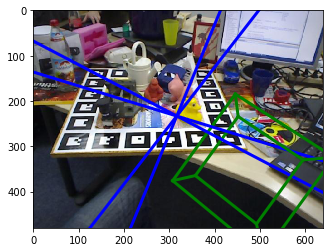

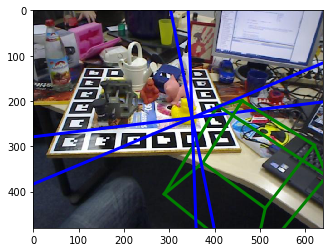

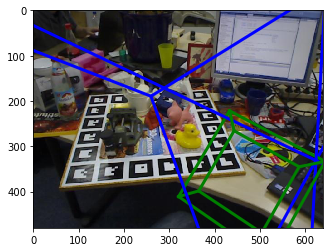

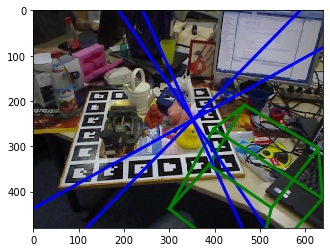

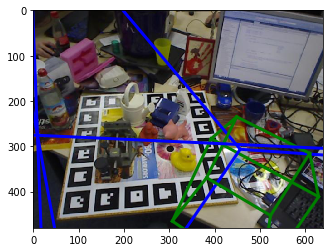

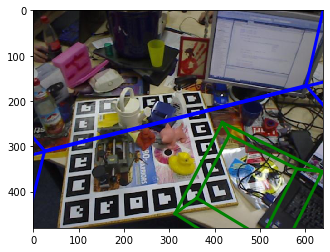

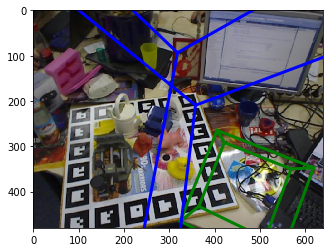

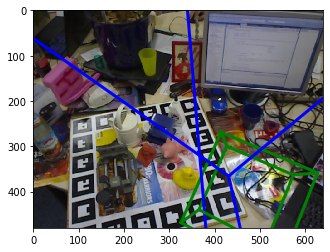

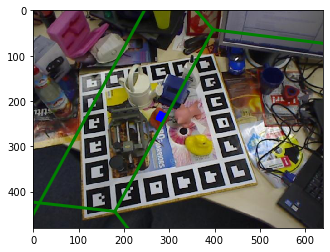

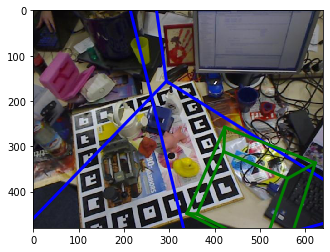

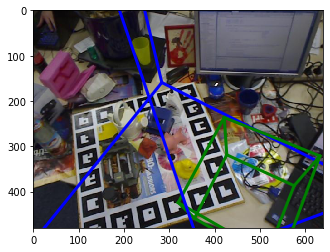

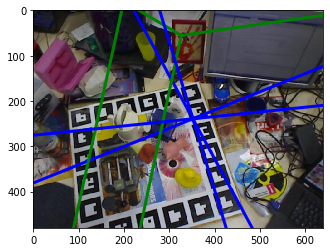

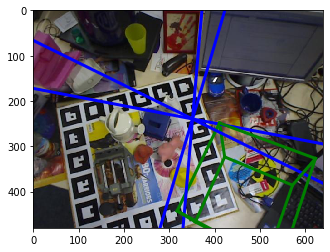

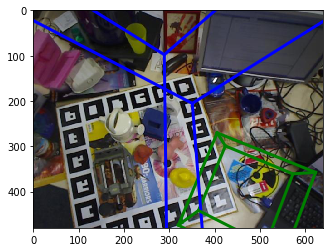

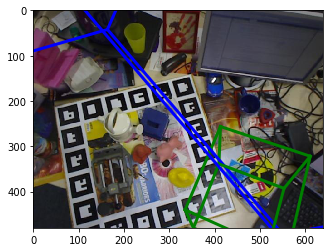

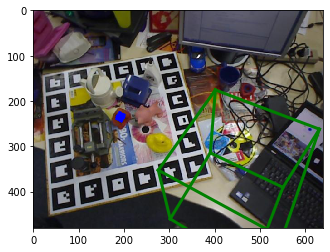

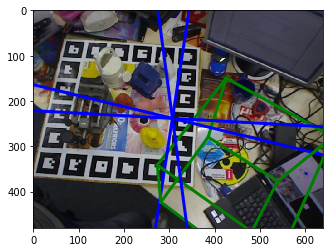

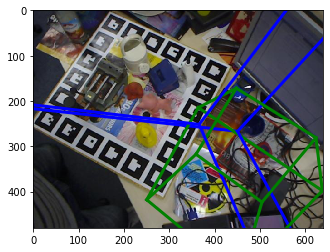

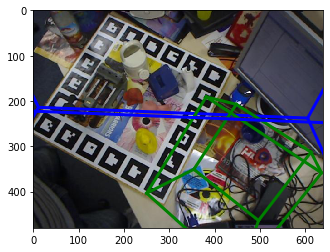

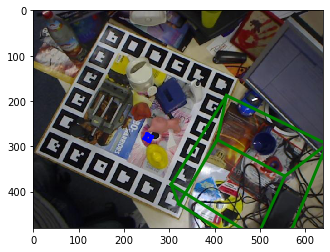

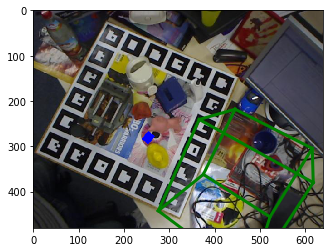

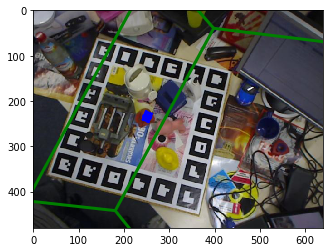

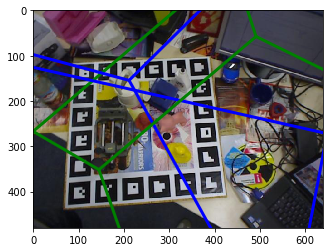

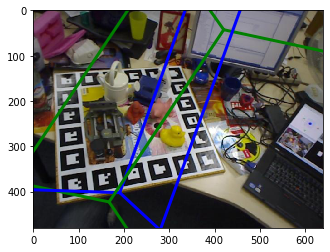

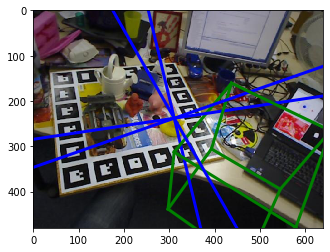

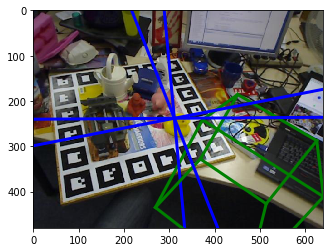

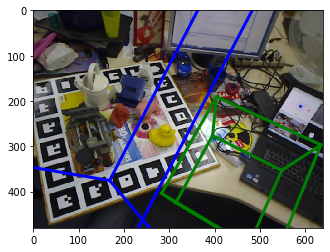

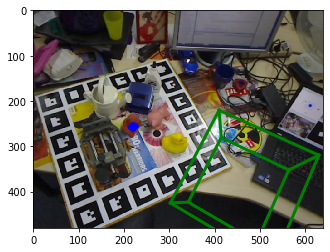

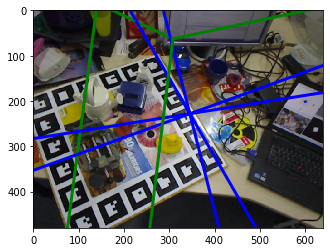

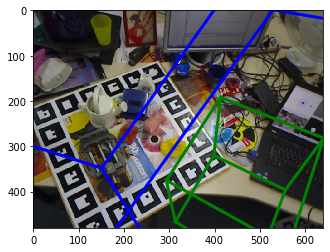

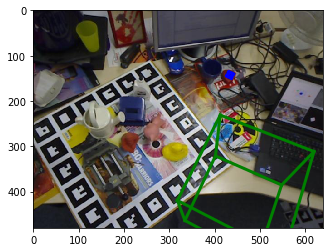

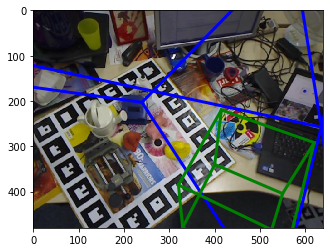

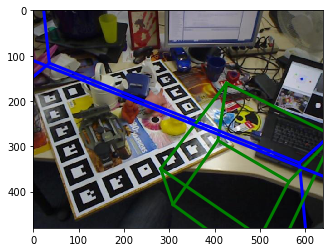

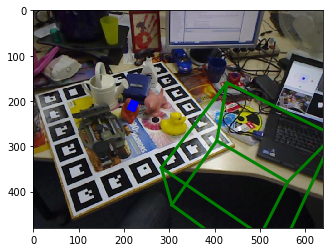

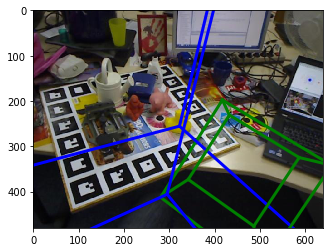

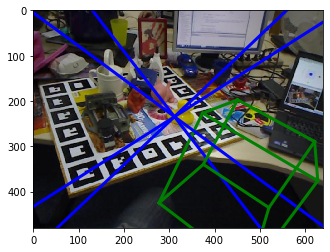

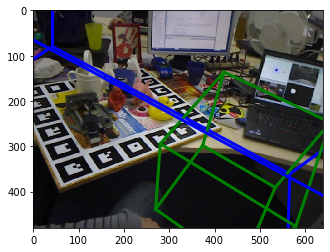

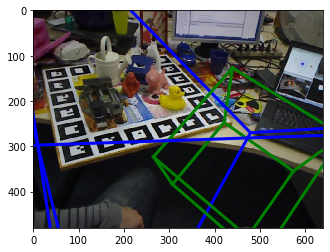

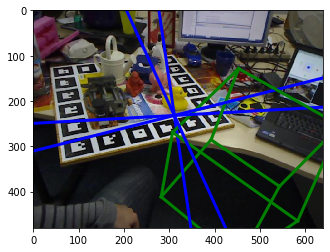

In [ ]:
def valid(datacfg, modelcfg, weightfile):
    def truths_length(truths, max_num_gt=50):
        for i in range(max_num_gt):
            if truths[i][1] == 0:
                return i

    # Parse configuration files
    data_options = read_data_cfg(datacfg)
    valid_images = data_options['valid']
    meshname     = data_options['mesh']
    backupdir    = data_options['backup']
    name         = data_options['name']
    gpus         = data_options['gpus'] 
    fx           = float(data_options['fx'])
    fy           = float(data_options['fy'])
    u0           = float(data_options['u0'])
    v0           = float(data_options['v0'])
    im_width     = int(data_options['width'])
    im_height    = int(data_options['height'])
    if not os.path.exists(backupdir):
        makedirs(backupdir)

    # Parameters
    seed = int(time.time())
    os.environ['CUDA_VISIBLE_DEVICES'] = gpus
    torch.cuda.manual_seed(seed)
    save            = False
    visualize       = True
    testtime        = True
    num_classes     = 1
    testing_samples = 0.0
    edges_corners = [[0, 1], [0, 2], [0, 4], [1, 3], [1, 5], [2, 3], [2, 6], [3, 7], [4, 5], [4, 6], [5, 7], [6, 7]]
    if save:
        makedirs(backupdir + '/ape')
        makedirs(backupdir + '/ape/gt')
        makedirs(backupdir + '/ape/pr')
    # To save
    testing_error_trans = 0.0
    testing_error_angle = 0.0
    testing_error_pixel = 0.0
    errs_2d             = []
    errs_3d             = []
    errs_trans          = []
    errs_angle          = []
    errs_corner2D       = []
    preds_trans         = []
    preds_rot           = []
    preds_corners2D     = []
    gts_trans           = []
    gts_rot             = []
    gts_corners2D       = []

    # Read object model information, get 3D bounding box corners
    mesh      = MeshPly(meshname)
    vertices  = np.c_[np.array(mesh.vertices), np.ones((len(mesh.vertices), 1))].transpose()
    corners3D = get_3D_corners(vertices)
    try:
        diam  = float(options['diam'])
    except:
        diam  = calc_pts_diameter(np.array(mesh.vertices))
        
    # Read intrinsic camera parameters
    intrinsic_calibration = get_camera_intrinsic(u0, v0, fx, fy)

    # Get validation file names
    with open(valid_images) as fp:
        tmp_files = fp.readlines()
        valid_files = [item.rstrip() for item in tmp_files]
    
    # Specicy model, load pretrained weights, pass to GPU and set the module in evaluation mode
    model = Darknet(modelcfg)
    model.print_network()
    model.load_weights(weightfile)
    model.cuda()
    model.eval()
    test_width    = model.test_width
    test_height   = model.test_height
    num_keypoints = model.num_keypoints 
    num_labels    = num_keypoints * 2 + 3

    # Get the parser for the test dataset
    valid_dataset = dataset.listDataset(valid_images, 
                                        shape=(test_width, test_height),
                                        shuffle=False,
                                        transform=transforms.Compose([transforms.ToTensor(),]))

    # Specify the number of workers for multiple processing, get the dataloader for the test dataset
    kwargs = {'num_workers': 4, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False, **kwargs) 

    logging("   Testing {}...".format(name))
    logging("   Number of test samples: %d" % len(test_loader.dataset))
    # Iterate through test batches (Batch size for test data is 1)
    count = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        
        # Images
        img = data[0, :, :, :]
        img = img.numpy().squeeze()
        img = np.transpose(img, (1, 2, 0))
        
        t1 = time.time()
        # Pass data to GPU
        data = data.cuda()
        target = target.cuda()
        # Wrap tensors in Variable class, set volatile=True for inference mode and to use minimal memory during inference
        data = Variable(data, volatile=True)
        t2 = time.time()
        # Forward pass
        output = model(data).data  
        t3 = time.time()
        # Using confidence threshold, eliminate low-confidence predictions
        all_boxes = get_region_boxes(output, num_classes, num_keypoints)        
        t4 = time.time()
        # Evaluation
        # Iterate through all batch elements
        for box_pr, target in zip([all_boxes], [target[0]]):
            # For each image, get all the targets (for multiple object pose estimation, there might be more than 1 target per image)
            truths = target.view(-1, num_keypoints*2+3)
            # Get how many objects are present in the scene
            num_gts    = truths_length(truths)
            # Iterate through each ground-truth object
            for k in range(num_gts):
                box_gt = list()
                for j in range(1, 2*num_keypoints+1):
                    box_gt.append(truths[k][j])
                box_gt.extend([1.0, 1.0])
                box_gt.append(truths[k][0])

                # Denormalize the corner predictions 
                corners2D_gt = np.array(np.reshape(box_gt[:18], [9, 2]), dtype='float32')
                corners2D_pr = np.array(np.reshape(box_pr[:18], [9, 2]), dtype='float32')
                corners2D_gt[:, 0] = corners2D_gt[:, 0] * im_width
                corners2D_gt[:, 1] = corners2D_gt[:, 1] * im_height          
                corners2D_pr[:, 0] = corners2D_pr[:, 0] * im_width
                corners2D_pr[:, 1] = corners2D_pr[:, 1] * im_height
                preds_corners2D.append(corners2D_pr)
                gts_corners2D.append(corners2D_gt)

                # Compute corner prediction error
                corner_norm = np.linalg.norm(corners2D_gt - corners2D_pr, axis=1)
                corner_dist = np.mean(corner_norm)
                errs_corner2D.append(corner_dist)
                
                # Compute [R|t] by pnp
                R_gt, t_gt = pnp(np.array(np.transpose(np.concatenate((np.zeros((3, 1)), corners3D[:3, :]), axis=1)), dtype='float32'),  corners2D_gt, np.array(intrinsic_calibration, dtype='float32'))
                R_pr, t_pr = pnp(np.array(np.transpose(np.concatenate((np.zeros((3, 1)), corners3D[:3, :]), axis=1)), dtype='float32'),  corners2D_pr, np.array(intrinsic_calibration, dtype='float32'))
                
                # Compute translation error
                trans_dist   = np.sqrt(np.sum(np.square(t_gt - t_pr)))
                errs_trans.append(trans_dist)
                
                # Compute angle error
                angle_dist   = calcAngularDistance(R_gt, R_pr)
                errs_angle.append(angle_dist)
                
                # Compute pixel error
                Rt_gt        = np.concatenate((R_gt, t_gt), axis=1)
                Rt_pr        = np.concatenate((R_pr, t_pr), axis=1)
                proj_2d_gt   = compute_projection(vertices, Rt_gt, intrinsic_calibration)
                proj_2d_pred = compute_projection(vertices, Rt_pr, intrinsic_calibration) 
                proj_corners_gt = np.transpose(compute_projection(corners3D, Rt_gt, intrinsic_calibration)) 
                proj_corners_pr = np.transpose(compute_projection(corners3D, Rt_pr, intrinsic_calibration)) 
                norm         = np.linalg.norm(proj_2d_gt - proj_2d_pred, axis=0)
                pixel_dist   = np.mean(norm)
                errs_2d.append(pixel_dist)

                if visualize:
                    # Visualize
                    plt.xlim((0, im_width))
                    plt.ylim((0, im_height))
                    plt.imshow(scipy.misc.imresize(img, (im_height, im_width)))
                    # Projections
                    for edge in edges_corners:
                        plt.plot(proj_corners_gt[edge, 0], proj_corners_gt[edge, 1], color='g', linewidth=3.0)
                        plt.plot(proj_corners_pr[edge, 0], proj_corners_pr[edge, 1], color='b', linewidth=3.0)
                    plt.gca().invert_yaxis()
                    plt.show()
                
                # Compute 3D distances
                transform_3d_gt   = compute_transformation(vertices, Rt_gt) 
                transform_3d_pred = compute_transformation(vertices, Rt_pr)  
                norm3d            = np.linalg.norm(transform_3d_gt - transform_3d_pred, axis=0)
                vertex_dist       = np.mean(norm3d)    
                errs_3d.append(vertex_dist)  

                # Sum errors
                testing_error_trans  += trans_dist
                testing_error_angle  += angle_dist
                testing_error_pixel  += pixel_dist
                testing_samples      += 1
                count = count + 1

                if save:
                    preds_trans.append(t_pr)
                    gts_trans.append(t_gt)
                    preds_rot.append(R_pr)
                    gts_rot.append(R_gt)

                    np.savetxt(backupdir + '/ape/gt/R_' + valid_files[count][-8:-3] + 'txt', np.array(R_gt, dtype='float32'))
                    np.savetxt(backupdir + '/ape/gt/t_' + valid_files[count][-8:-3] + 'txt', np.array(t_gt, dtype='float32'))
                    np.savetxt(backupdir + '/ape/pr/R_' + valid_files[count][-8:-3] + 'txt', np.array(R_pr, dtype='float32'))
                    np.savetxt(backupdir + '/ape/pr/t_' + valid_files[count][-8:-3] + 'txt', np.array(t_pr, dtype='float32'))
                    np.savetxt(backupdir + '/ape/gt/corners_' + valid_files[count][-8:-3] + 'txt', np.array(corners2D_gt, dtype='float32'))
                    np.savetxt(backupdir + '/ape/pr/corners_' + valid_files[count][-8:-3] + 'txt', np.array(corners2D_pr, dtype='float32'))


        t5 = time.time()

    # Compute 2D projection error, 6D pose error, 5cm5degree error
    px_threshold = 5 # 5 pixel threshold for 2D reprojection error is standard in recent sota 6D object pose estimation works 
    eps          = 1e-5
    acc          = len(np.where(np.array(errs_2d) <= px_threshold)[0]) * 100. / (len(errs_2d)+eps)
    acc5cm5deg   = len(np.where((np.array(errs_trans) <= 0.05) & (np.array(errs_angle) <= 5))[0]) * 100. / (len(errs_trans)+eps)
    acc3d10      = len(np.where(np.array(errs_3d) <= diam * 0.1)[0]) * 100. / (len(errs_3d)+eps)
    acc5cm5deg   = len(np.where((np.array(errs_trans) <= 0.05) & (np.array(errs_angle) <= 5))[0]) * 100. / (len(errs_trans)+eps)
    corner_acc   = len(np.where(np.array(errs_corner2D) <= px_threshold)[0]) * 100. / (len(errs_corner2D)+eps)
    mean_err_2d  = np.mean(errs_2d)
    mean_corner_err_2d = np.mean(errs_corner2D)
    nts = float(testing_samples)

    if testtime:
        print('-----------------------------------')
        print('  tensor to cuda : %f' % (t2 - t1))
        print('    forward pass : %f' % (t3 - t2))
        print('get_region_boxes : %f' % (t4 - t3))
        print(' prediction time : %f' % (t4 - t1))
        print('            eval : %f' % (t5 - t4))
        print('-----------------------------------')

    # Print test statistics
    logging('Results of {}'.format(name))
    logging('   Acc using {} px 2D Projection = {:.2f}%'.format(px_threshold, acc))
    logging('   Acc using 10% threshold - {} vx 3D Transformation = {:.2f}%'.format(diam * 0.1, acc3d10))
    logging('   Acc using 5 cm 5 degree metric = {:.2f}%'.format(acc5cm5deg))
    logging("   Mean 2D pixel error is %f, Mean vertex error is %f, mean corner error is %f" % (mean_err_2d, np.mean(errs_3d), mean_corner_err_2d))
    logging('   Translation error: %f m, angle error: %f degree, pixel error: % f pix' % (testing_error_trans/nts, testing_error_angle/nts, testing_error_pixel/nts) )

    if save:
        predfile = backupdir + '/predictions_linemod_' + name +  '.mat'
        scipy.io.savemat(predfile, {'R_gts': gts_rot, 't_gts':gts_trans, 'corner_gts': gts_corners2D, 'R_prs': preds_rot, 't_prs':preds_trans, 'corner_prs': preds_corners2D})

datacfg    = 'cfg/ape.data'
modelcfg   = 'cfg/yolo-pose.cfg'
weightfile = 'backup/ape/model.weights'
valid(datacfg, modelcfg, weightfile)
        